## Preparation

In [1]:
# Libraries 
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tf_utils
from time import time
from datetime import date
import json
import pathlib
import albumentations as A

In [3]:
# Parameters
EPOCHS = 100
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 2603
FPATH = 'D:/Master thesis/saved_models'
tf.random.set_seed(SEED)
np.random.seed(SEED)
tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU')]

In [4]:
# Dataset preparation
train_part, valid_part, test_part = 0.7, 0.15, 0.15

# Loading
kaggle_ds = tf.keras.utils.image_dataset_from_directory(
    'kaggle dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

nature_ds = tf.keras.utils.image_dataset_from_directory(
    'nature dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = kaggle_ds.class_names
no_classes = len(class_names)

# Splitting
train_ds, valid_ds, test_ds = tf_utils.get_dataset_partitions(kaggle_ds, train_part, valid_part, test_part, seed=SEED)
print(f'Batches ({BATCH_SIZE} images per batch) in subsets:')
print(f'Train: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

# Normalization
kaggle_ds = kaggle_ds.map(tf_utils.normalize)
train_ds = train_ds.map(tf_utils.normalize)
valid_ds = valid_ds.map(tf_utils.normalize)
test_ds = test_ds.map(tf_utils.normalize)
nature_ds = nature_ds.map(tf_utils.normalize)

Found 10033 files belonging to 75 classes.
Found 138 files belonging to 75 classes.
Batches (32 images per batch) in subsets:
Train: 219
Validation: 47
Test: 48


## Fitting

#### Inception

In [21]:
# Constructing a model
name = 'InceptionV3'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dropout(rate=0.4, seed=SEED))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

#### VGG

In [17]:
# Constructing a model
name = 'VGG19'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1000, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### ResNet

In [4]:
# Constructing a model
name = 'ResNet50'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(1000, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

#### MobileNet

In [5]:
# Constructing a model
name = 'MobileNet'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

### Fit

In [5]:
# Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 dense_1 (Dense)             (None, 75)                75075     
                                                                 
Total params: 25,711,787
Trainable params: 25,658,667
Non-trainable params: 53,120
_________________________________________________________________


In [6]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

training_date = date.today()
model_dir_name = f'{model.name}_({training_date})_'
ctr = [p.name[:-1] for p in pathlib.Path(FPATH).glob('*')].count(model_dir_name)
model_dir_name += str(ctr)

print(model_dir_name)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f'{FPATH}/{model_dir_name}/model',
        monitor='val_accuracy',
        save_best_only=True
    )
]

t0 = time()

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_ds,
    steps_per_epoch=len(train_ds),
    validation_steps=len(valid_ds),
    callbacks=callbacks
)

training_time = time() - t0

ResNet50_(2023-04-13)_1
Epoch 1/100
219/219 [==============================] - ETA: 0s - loss: 1.8885 - accuracy: 0.5168

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/ResNet50_(2023-04-13)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/ResNet50_(2023-04-13)_1\model\assets


219/219 [==============================] - 547s 2s/step - loss: 1.8885 - accuracy: 0.5168 - val_loss: 5.7383 - val_accuracy: 0.0175
Epoch 2/100
217/219 [============================>.] - ETA: 3s - loss: 0.6529 - accuracy: 0.8026

KeyboardInterrupt: 

### Evaluation and saving

In [20]:
model = tf.keras.models.load_model(f'{FPATH}/{model_dir_name}/model')

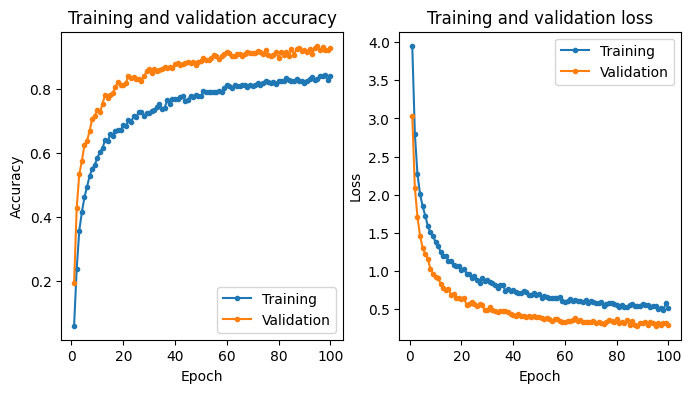

In [21]:
tf_utils.plot_history(history)

tf_utils.save_json(f'{FPATH}/{model_dir_name}/history.json', history.history)
#json.dump(history.history, open(f'{FPATH}/{model_dir_name}/history.json', 'w'))

In [22]:
test_loss, test_accuracy = model.evaluate(test_ds)
print('Kaggle set evaluation: ')
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

48/48 [==============================] - 80s 439ms/step - loss: 0.3065 - accuracy: 0.9199
Kaggle set evaluation: 
Test loss: 0.30653977394104004
Test accuracy: 0.919921875


1/1 [==============================] - 1s 1s/step


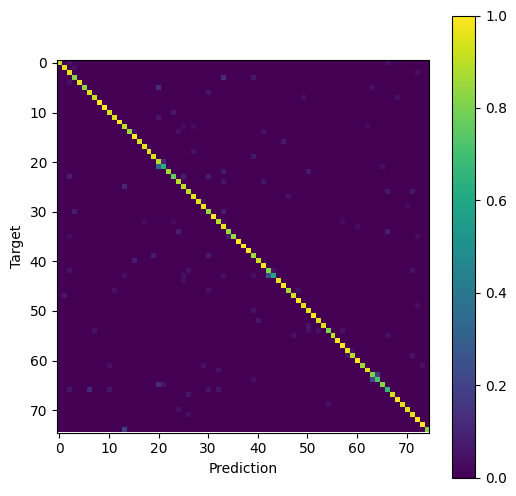

In [23]:
targets = []
predictions = []
for test_images, test_labels in test_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(m,figsize=(6,6))
plt.show()

In [24]:
nature_test_loss, nature_test_accuracy = model.evaluate(nature_ds)
print('Nature set evaluation: ')
print(f'Test loss: {nature_test_loss}')
print(f'Test accuracy: {nature_test_accuracy}')

5/5 [==============================] - 8s 381ms/step - loss: 1.0195 - accuracy: 0.7029
Nature set evaluation: 
Test loss: 1.0194560289382935
Test accuracy: 0.7028985619544983


1/1 [==============================] - 4s 4s/step


d:\Master thesis\MasterThesis-1\tf_utils.py:182: RuntimeWarning: invalid value encountered in divide
  mat[i, :] /= normalization[i]


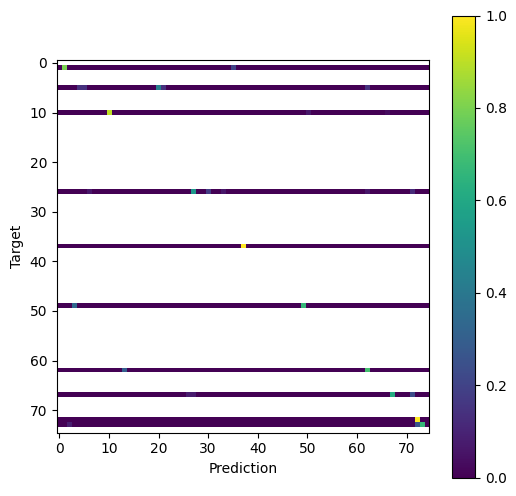

In [25]:
targets = []
predictions = []
for test_images, test_labels in nature_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

nature_m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(nature_m,figsize=(6,6))
plt.show()

In [26]:
# Evaluating inference time
t0 = time()
model.predict(kaggle_ds)
t1 = time()
inf_time = (t1 - t0) * 1000 / 10033

314/314 [==============================] - 142s 437ms/step


In [27]:
info = {
    'date': training_date.isoformat(),
    'duration': training_time,
    'name': model.name,
    'batch_size': BATCH_SIZE,
    'seed': SEED,
    'epochs': EPOCHS,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'nature_accuracy': nature_test_accuracy,
    'nature_loss': nature_test_loss,
    'inference_time': inf_time,
    'comment': '',
    'test_confusion': m.tolist(),
    'nature_confusion': nature_m.tolist()
    }

tf_utils.save_json(f'{FPATH}/{model_dir_name}/info.json', info)
#json.dump(info, open(f'{FPATH}/{model_dir_name}/info.json', 'w'))

## Influence of image quality

In [11]:
# Listing available models
model_paths = list(pathlib.Path(FPATH).glob('*'))
for p in model_paths:
    print(p.name)

InceptionV3_(2023-04-07)_0
InceptionV3_(2023-04-08)_0
InceptionV3_(2023-04-08)_1
MobileNetV2_(2023-03-24)_0
MobileNet_(2023-03-23)_0
MobileNet_(2023-04-09)_0
MobileNet_(2023-04-09)_1
ResNet50v2_(2023-03-25)_0
ResNet50v2_(2023-04-09)_0
ResNet50v2_(2023-04-10)_0
ResNet_(2023-03-22)_1
VGG16_(2023-03-20)_0
VGG16_(2023-04-10)_0
VGG16_(2023-04-10)_1
VGG19_(2023-03-20)_0
VGG19_(2023-04-11)_0
VGG19_(2023-04-12)_0


In [12]:
# Auxiliary functions
def transform_image(image, transforms):
    data = {'image': image}
    aug_data = transforms(**data)
    aug_img = aug_data['image']
    return aug_img

def prepare_mapping(transforms):
    def aug_fn(image):
        return transform_image(image, transforms)
    
    def mapping(image, label):
        aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
        return aug_img, label
    
    return mapping


### Brightness

In [15]:
prob_n = 5
limit_n = 10
for path in model_paths[0:1]:
    info = tf_utils.load_json(str(path) + '/info.json')
    np.random.seed(info['seed'])
    tf.random.set_seed(info['seed'])

    model = tf.keras.models.load_model(str(path) + '/model')
    print(model.name)

    rows = []
    for lower_b in np.arange(-1, 1, 2 / limit_n):
        for prob in np.linspace(0, 1, prob_n):
            print(f'Lower_b={lower_b:2.1f}, prob={prob:.2f}')
            upper_b = lower_b + 2 / limit_n
            transform = A.Compose([A.RandomBrightnessContrast(brightness_limit=(lower_b, upper_b), contrast_limit=0, p=prob)])
            new_test_ds = test_ds.map(prepare_mapping(transform)).prefetch(tf.data.AUTOTUNE)
            loss, accuracy = model.evaluate(new_test_ds, verbose=False)
            print(f'Loss: {loss}, Accuracy: {accuracy}')
            row = {
                'loss': loss,
                'accuracy': accuracy,
                'brightness': f'{lower_b:.2f}-{upper_b:.2f}',
                'probability': prob
            }
            rows.append(row)
        
    df = pd.DataFrame(rows)
    df.head()

InceptionV3
Lower_b=-1.0, prob=0.00
Loss: 0.1631995141506195, Accuracy: 0.9733073115348816
Lower_b=-1.0, prob=0.25
Loss: 1.2048063278198242, Accuracy: 0.84765625
Lower_b=-1.0, prob=0.50
Loss: 2.8567605018615723, Accuracy: 0.6263021230697632
Lower_b=-1.0, prob=0.75
Loss: 4.917882442474365, Accuracy: 0.3671875
Lower_b=-1.0, prob=1.00
Loss: 6.010642051696777, Accuracy: 0.216796875
Lower_b=-0.6, prob=0.00
Loss: 0.13577573001384735, Accuracy: 0.978515625
Lower_b=-0.6, prob=0.25
Loss: 0.37612253427505493, Accuracy: 0.939453125
Lower_b=-0.6, prob=0.50
Loss: 0.5350469946861267, Accuracy: 0.9158448576927185
Lower_b=-0.6, prob=0.75
Loss: 0.624856173992157, Accuracy: 0.8893229365348816
Lower_b=-0.6, prob=1.00
Loss: 0.7411090135574341, Accuracy: 0.8691650629043579
Lower_b=-0.2, prob=0.00
Loss: 0.1320546269416809, Accuracy: 0.9798177480697632
Lower_b=-0.2, prob=0.25
Loss: 0.18387848138809204, Accuracy: 0.97265625
Lower_b=-0.2, prob=0.50
Loss: 0.17277395725250244, Accuracy: 0.9733073115348816
Lower_

In [23]:
(9*60+8)/25

21.92

## Augmentation

In [17]:
import albumentations as A
from functools import partial

In [52]:
transforms = A.Compose([A.RandomBrightness(limit=(-1,-.9), p=1)])
def aug_fn(image):
    data = {'image': image}
    aug_data = transforms(**data)
    aug_img = aug_data['image']
    return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img, label

c:\Users\Admin\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


4022.582773738438 0.06186209571300943


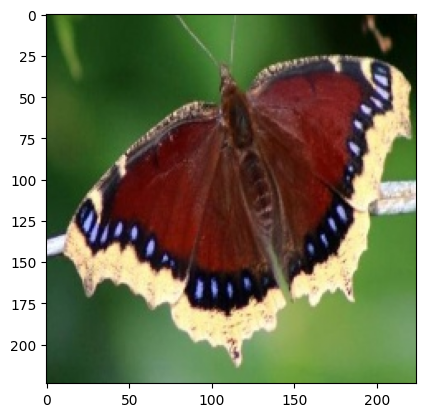

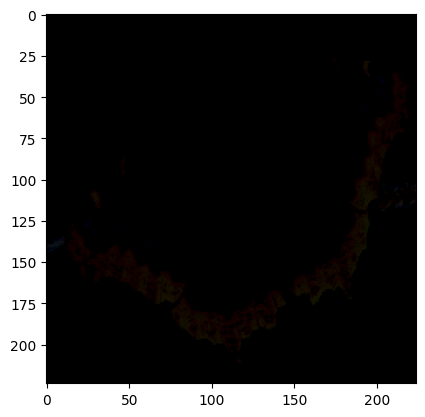

In [53]:
img = plt.imread('kaggle dataset/nymphalis antiopa/0005.jpg')
print(img.var(), (img/255).var())
plt.imshow(img/255)
plt.show()

img2 = aug_fn((img/255).astype(np.float32))
plt.imshow(img2)
plt.show()

In [21]:
img2 < 0

array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False,

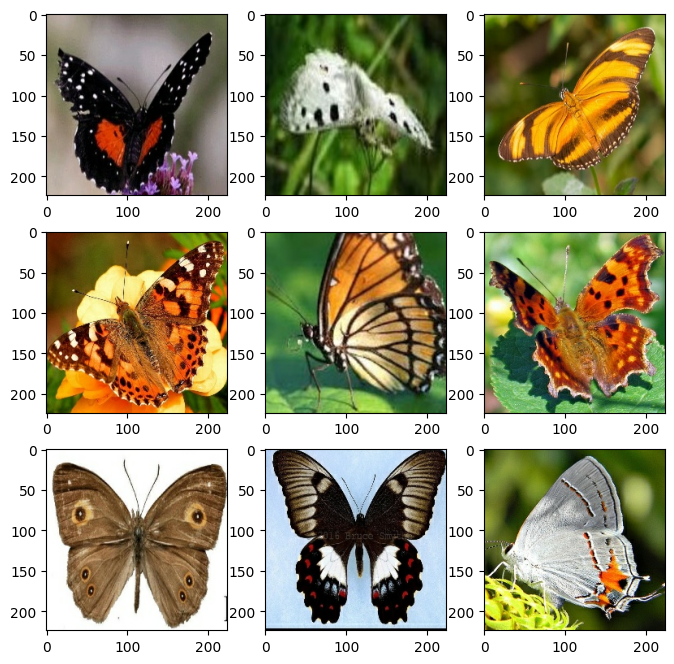

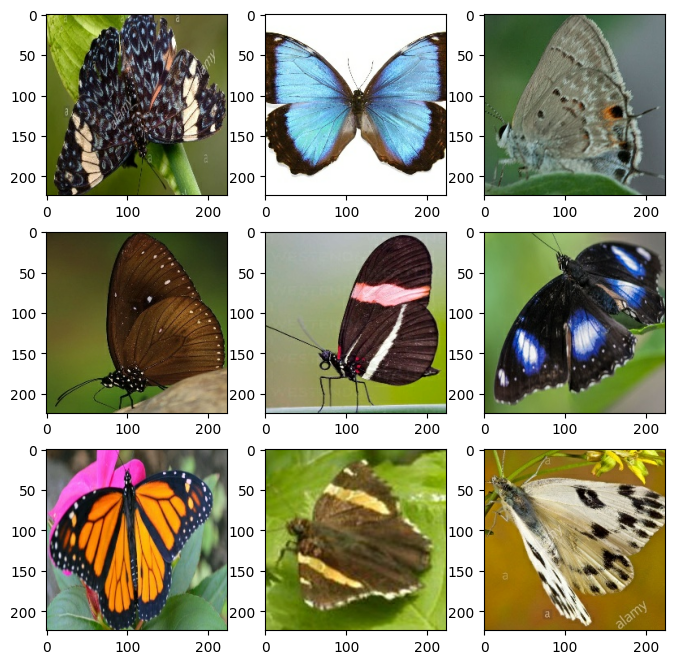

In [6]:
plt.figure(figsize=(8,8))
x = list(train_ds.take(1))
for i, l in x:
    for itr in range(9):
        plt.subplot(3,3,itr+1)
        plt.imshow(i[itr].numpy())

plt.show()

plt.figure(figsize=(8,8))
x = list(train_ds.map(process_data).prefetch(tf.data.AUTOTUNE).take(1))
for i, l in x:
    for itr in range(9):
        plt.subplot(3,3,itr+1)
        plt.imshow(i[itr].numpy())

plt.show()

In [19]:
#model = tf.keras.models.load_model(f'{FPATH}/ResNet50v2_(2023-03-25)_0/model')
a, l = model.evaluate(test_ds)
a2, l2 = model.evaluate(test_ds.map(process_data).prefetch(tf.data.AUTOTUNE))
print(a,l)
print(a2,l2)

48/48 [==============================] - 26s 239ms/step - loss: 9.9634 - accuracy: 0.4948
0.1470971703529358 0.9772135615348816
9.963364601135254 0.4947916865348816


In [22]:
dir = pathlib.Path('D:/Master thesis/saved_models')
for p in dir.glob('*'):
    try:
        with open(str(p)+'\\info.json') as src:
            info = json.load(src)
            print(p.name)
            print(f"\tKaggle: {info['test_accuracy']}, nature: {info['nature_accuracy']}")
    except:
        print(f'{p.name} has no info file')
        

MobileNetV2_(2023-03-24)_0
	Kaggle: 0.9596354365348816, nature: 0.8115942478179932
MobileNet_(2023-03-23)_0
	Kaggle: 0.9752604365348816, nature: 0.8333333730697632
ResNet50v2_(2023-03-25)_0
	Kaggle: 0.9654948115348816, nature: 0.760869562625885
ResNet_(2023-03-22)_1
	Kaggle: 0.9680989980697632, nature: 0.782608687877655
VGG16_(2023-03-16)_0
	Kaggle: 0.9075521230697632, nature: 0.7681159377098083
VGG16_(2023-03-16)_1
	Kaggle: 0.927734375, nature: 0.695652186870575
VGG16_(2023-03-16)_2
	Kaggle: 0.9420573115348816, nature: 0.7028985619544983
VGG16_(2023-03-16)_3
	Kaggle: 0.9309896230697632, nature: 0.7028985619544983
VGG16_(2023-03-17)_0
	Kaggle: 0.9498698115348816, nature: 0.7536231875419617
VGG16_(2023-03-17)_1
	Kaggle: 0.9440104365348816, nature: 0.7318840622901917
VGG16_(2023-03-17)_2 has no info file
VGG16_(2023-03-17)_3
	Kaggle: 0.9322916865348816, nature: 0.7463768124580383
VGG16_(2023-03-18)_0 has no info file
VGG16_(2023-03-18)_1
	Kaggle: 0.9140625, nature: 0.695652186870575
VGG1

In [4]:
chosen_models = ['VGG16_(2023-03-20)_0', 'VGG19_(2023-03-20)_0', 'ResNet_(2023-03-22)_1', 'ResNet50v2_(2023-03-25)_0', 'MobileNet_(2023-03-23)_0', 'MobileNetV2_(2023-03-24)_0']
paths = [f'{FPATH}/{p}' for p in chosen_models]


In [ ]:

noised_test = test_ds.map(process_data).prefetch(tf.data.AUTOTUNE)
for p in paths:
    model = tf.keras.models.load_model(p + '/model')
    l, a = model.evaluate(noised_test)
    with open(p + '/info.json') as src1:
        info = json.load(src1)
        info['noised_loss'] = l
        info['noised_accuracy'] = a
        
        with open(p + '/info.json', 'w') as src2:
            json.dump(info, src2)
        
tf.keras.applications.mobi

Model: VGG16
Time: 9182.725998878479
Epochs: 100
T/E: 91.82725998878479
Accuracy:
 kaggle: 0.9420573115348816, nature: 0.7681159377098083, noised: 0.4583333432674408


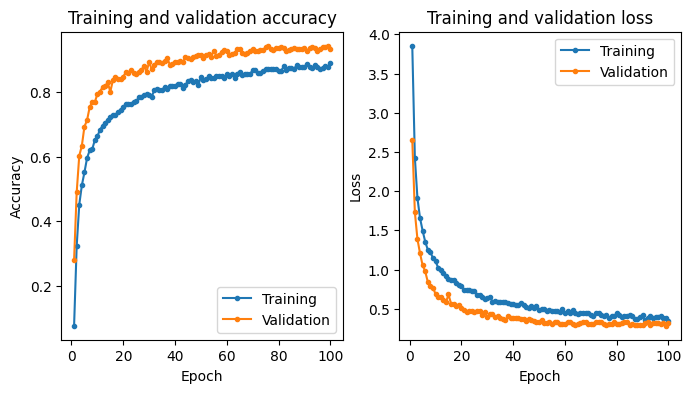

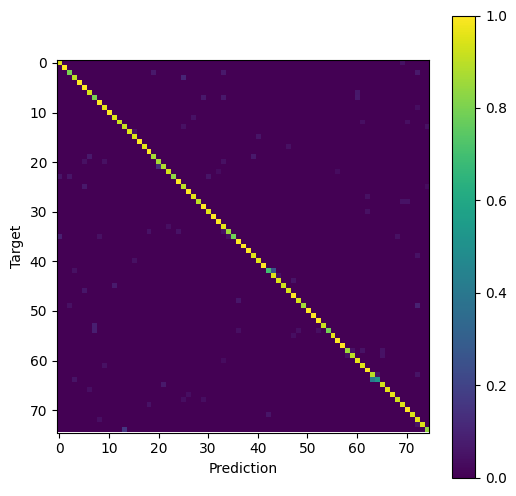

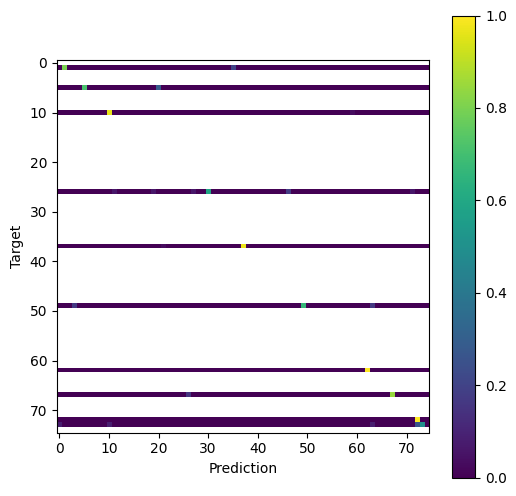

Model: VGG19
Time: 11790.862979412079
Epochs: 100
T/E: 117.90862979412078
Accuracy:
 kaggle: 0.9173177480697632, nature: 0.760869562625885, noised: 0.4505208432674408


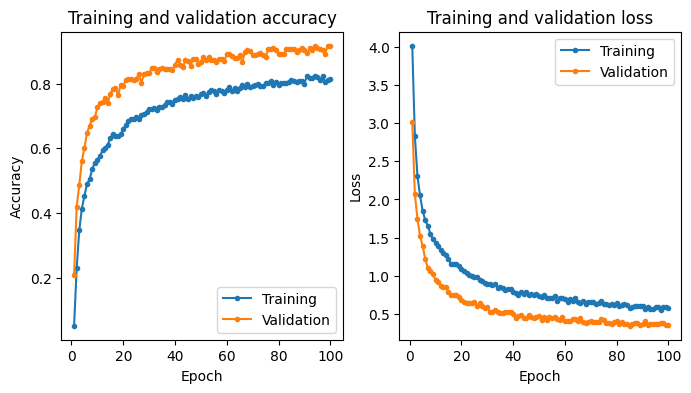

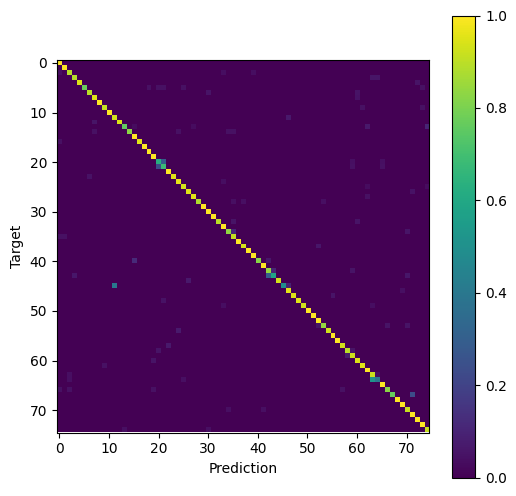

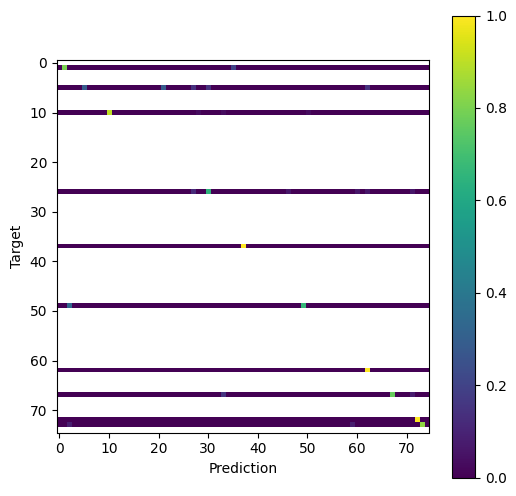

Model: ResNet
Time: 11135.328214406967
Epochs: 50
T/E: 222.70656428813933
Accuracy:
 kaggle: 0.9680989980697632, nature: 0.782608687877655, noised: 0.513671875


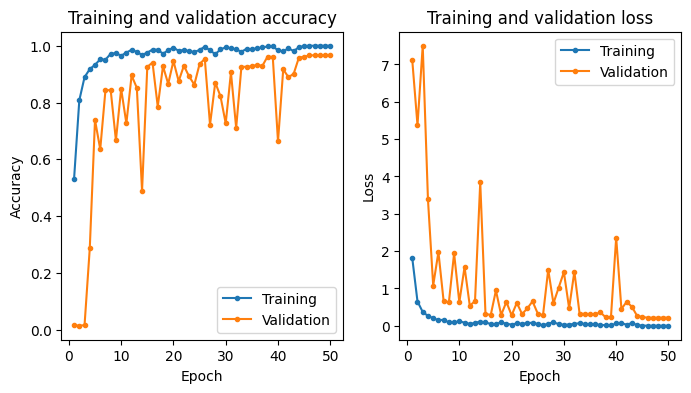

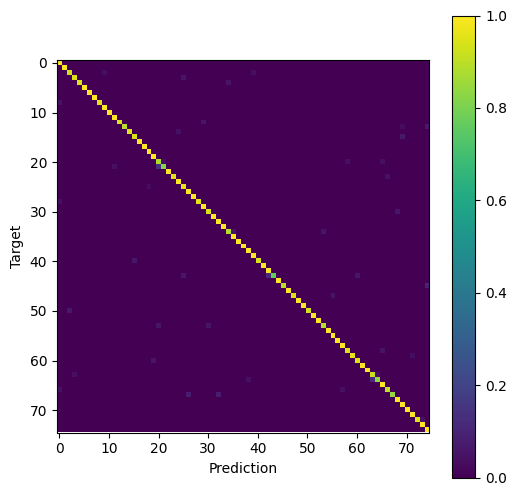

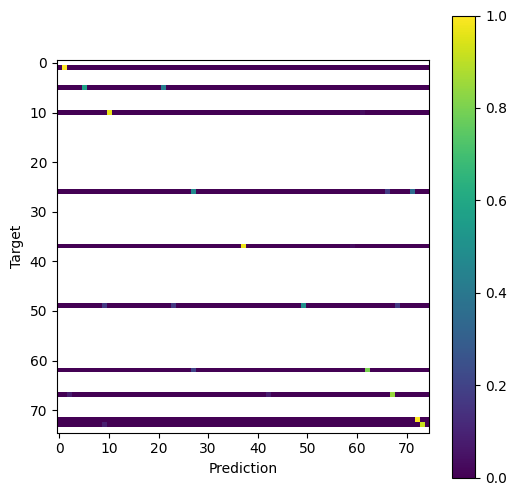

Model: ResNet50v2
Time: 27420.117421388626
Epochs: 100
T/E: 274.20117421388625
Accuracy:
 kaggle: 0.9654948115348816, nature: 0.760869562625885, noised: 0.4583333432674408


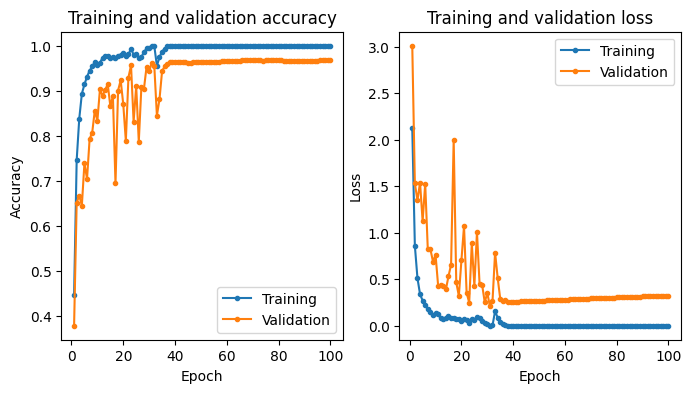

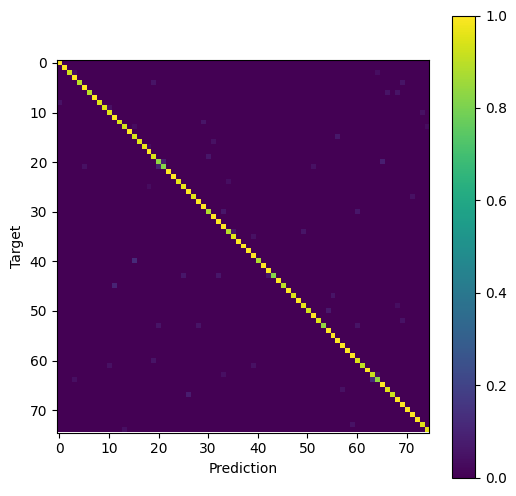

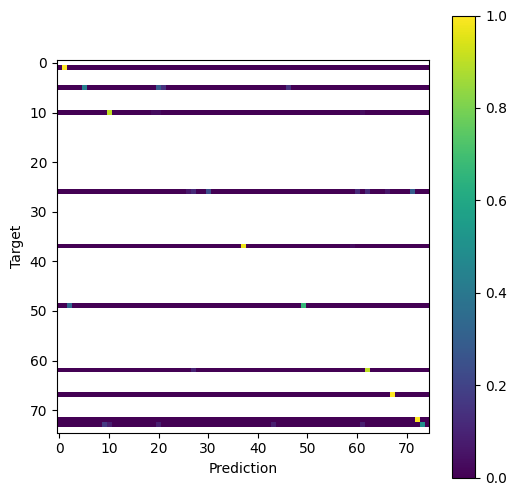

Model: MobileNet
Time: 8664.782270669937
Epochs: 100
T/E: 86.64782270669937
Accuracy:
 kaggle: 0.9752604365348816, nature: 0.8333333730697632, noised: 0.4134114682674408


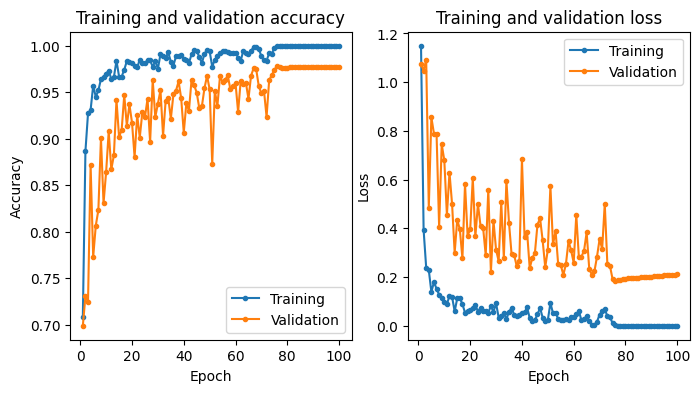

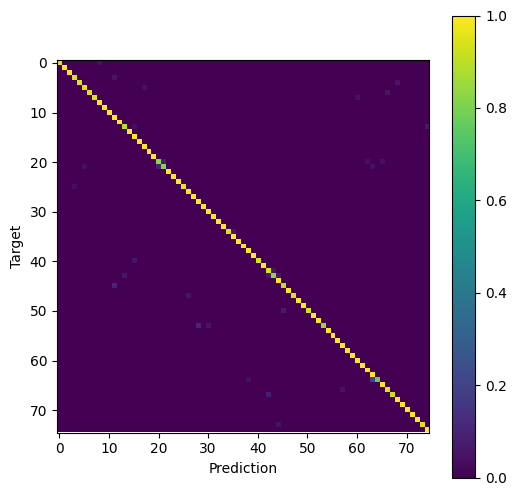

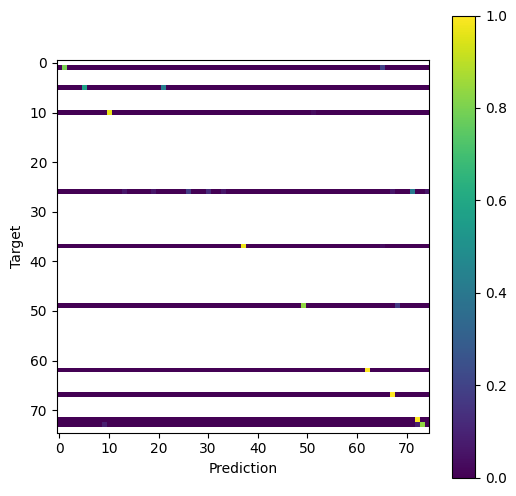

Model: MobileNetV2
Time: 67005.59485816956
Epochs: 100
T/E: 670.0559485816956
Accuracy:
 kaggle: 0.9596354365348816, nature: 0.8115942478179932, noised: 0.4674479365348816


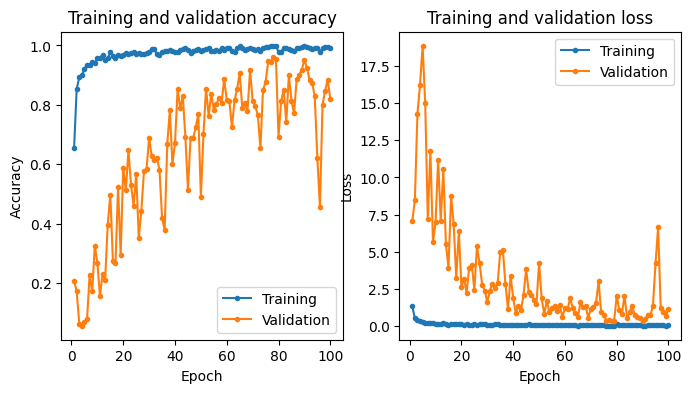

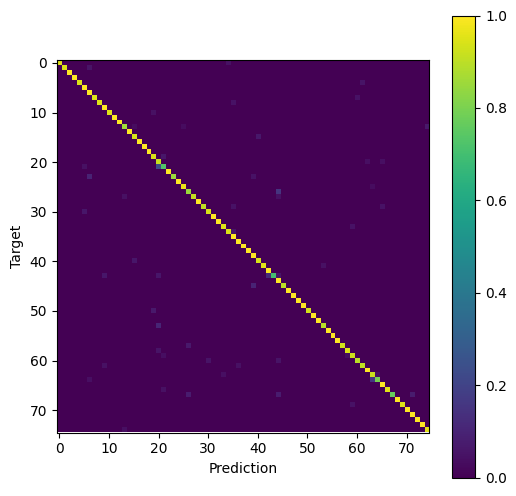

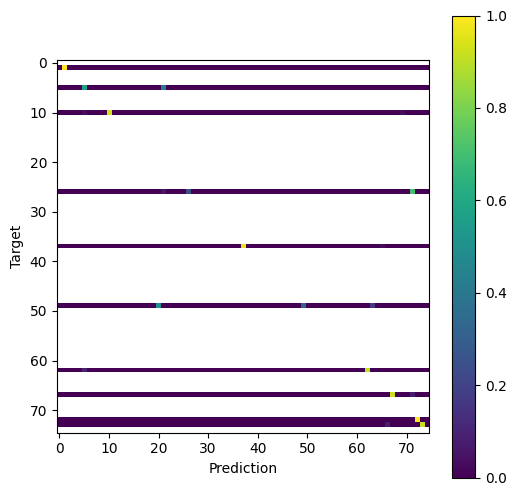

In [7]:
for p in paths:
    with open(p + '/info.json') as src1, open(p + '/history.json') as src2:
        info = json.load(src1)
        history = json.load(src2)
        class h:
            def __init__(self, his):
                self.history = his
        
    print(f"Model: {info['name']}")
    print(f"Time: {info['duration']}")
    try:
        print(f"Epochs: {info['epochs']}")
        print(f"T/E: {info['duration']/info['epochs']}")
    except:
        print()
    print(f"Accuracy:\n kaggle: {info['test_accuracy']}, nature: {info['nature_accuracy']}, noised: {info['noised_accuracy']}")
    tf_utils.plot_history(h(history))
    plt.show()
    tf_utils.plot_confusion_matrix(np.array(info['test_confusion']),figsize=(6,6))
    plt.show()
    tf_utils.plot_confusion_matrix(np.array(info['nature_confusion']),figsize=(6,6))
    plt.show()